<a href="https://colab.research.google.com/github/Kryptera-K/ETH-BullBear-Fusion-Strategy/blob/main/ETH_USD_D1_%5B'BearP_Higher_0'%2C_'BullP_Rising'%5D%5B'KC_Close_Below_Upper'%2C_'DI__Change_Direction_Upward'%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install vectorbt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.7/527.7 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 27.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

# -------------------------
# Parameters
# -------------------------
symbol = "ETH-USD"
start_date = "2000-01-01"
end_date = "2026-01-01"
interval = "1d"

# -------------------------
# Download Data
# -------------------------
df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)
df

/tmp/ipython-input-2317551387.py:17: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)
[*********************100%***********************]  1 of 1 completed


,Close,High,Low,Open,Volume
Date,,,,,
2017-11-09,320.884003,329.451996,307.056000,308.644989,893249984
2017-11-10,299.252991,324.717987,294.541992,320.670990,885985984
2017-11-11,314.681000,319.453003,298.191986,298.585999,842300992
2017-11-12,307.907990,319.153015,298.513000,314.690002,1613479936
2017-11-13,316.716003,328.415009,307.024994,307.024994,1041889984
...,...,...,...,...,...
2025-09-22,4202.877441,4457.082520,4092.396729,4451.580566,58221334533
2025-09-23,4165.503906,4227.731445,4120.815430,4203.021484,32460075911
2025-09-24,4153.469238,4206.901855,4081.347656,4165.412598,33538388785


/tmp/ipython-input-2788310541.py:17: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)
[*********************100%***********************]  1 of 1 completed


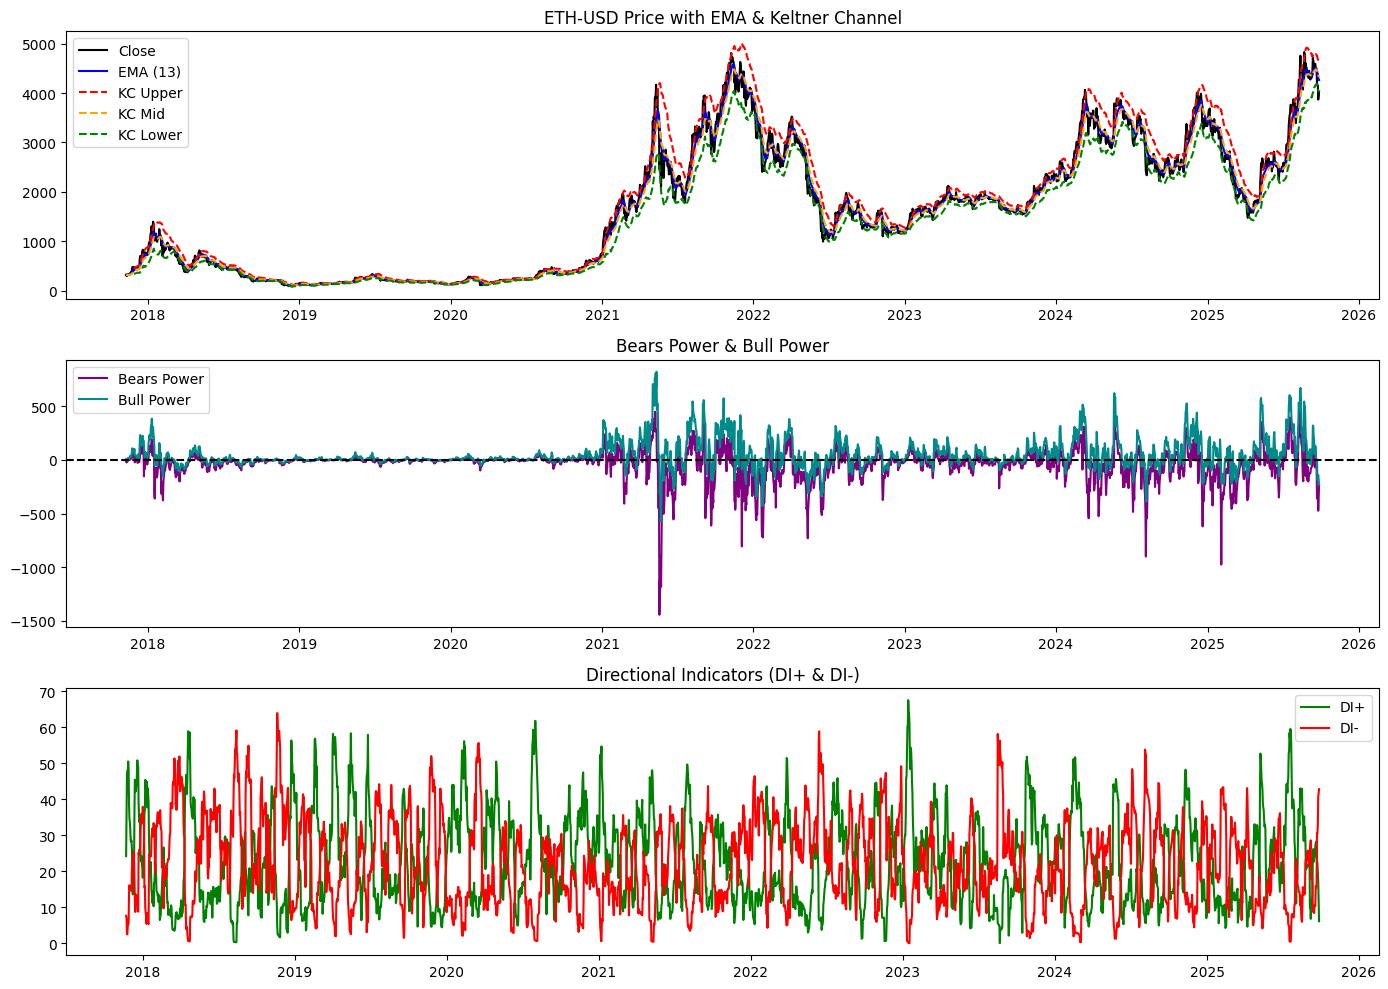

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

# -------------------------
# Parameters
# -------------------------
symbol = "ETH-USD"
start_date = "2000-01-01"
end_date = "2026-01-01"
interval = "1d"

# -------------------------
# Download Data
# -------------------------
df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)

# -------------------------
# Bears Power
# -------------------------
ema_period = 13
df['EMA'] = df['Close'].ewm(span=ema_period, adjust=False).mean()
df['Bears_Power'] = df['Low'] - df['EMA']

df['BearP_Higher_0'] = df['Bears_Power'] > 0

# -------------------------
# Bull Power
# -------------------------
df['Bull_Power'] = df['High'] - df['EMA']
df['BullP_Rising'] = df['Bull_Power'] > df['Bull_Power'].shift(1)

# -------------------------
# Keltner Channel
# -------------------------
kc_period = 20
kc_multiplier = 2

df['TP'] = (df['High'] + df['Low'] + df['Close']) / 3
df['KC_Mid'] = df['TP'].ewm(span=kc_period, adjust=False).mean()

df['H-L'] = df['High'] - df['Low']
df['H-PC'] = abs(df['High'] - df['Close'].shift(1))
df['L-PC'] = abs(df['Low'] - df['Close'].shift(1))
df['TR'] = df[['H-L','H-PC','L-PC']].max(axis=1)
df['ATR'] = df['TR'].rolling(kc_period).mean()

df['KC_Upper'] = df['KC_Mid'] + kc_multiplier * df['ATR']
df['KC_Lower'] = df['KC_Mid'] - kc_multiplier * df['ATR']
df['KC_Close_Below_Upper'] = df['Close'] < df['KC_Upper']

# -------------------------
# DI- (Directional Indicator)
# -------------------------
def calculate_di(df, period=14):
    df = df.copy()
    df['H-L'] = df['High'] - df['Low']
    df['H-PC'] = abs(df['High'] - df['Close'].shift(1))
    df['L-PC'] = abs(df['Low'] - df['Close'].shift(1))
    df['TR'] = df[['H-L', 'H-PC', 'L-PC']].max(axis=1)

    df['+DM'] = np.where((df['High'] - df['High'].shift(1)) > (df['Low'].shift(1) - df['Low']),
                         np.maximum(df['High'] - df['High'].shift(1), 0), 0)
    df['-DM'] = np.where((df['Low'].shift(1) - df['Low']) > (df['High'] - df['High'].shift(1)),
                         np.maximum(df['Low'].shift(1) - df['Low'], 0), 0)

    df['TR_smooth'] = df['TR'].rolling(period).sum()
    df['+DM_smooth'] = df['+DM'].rolling(period).sum()
    df['-DM_smooth'] = df['-DM'].rolling(period).sum()

    df['DI+'] = 100 * (df['+DM_smooth'] / df['TR_smooth'])
    df['DI-'] = 100 * (df['-DM_smooth'] / df['TR_smooth'])
    return df

df = calculate_di(df, period=14)

# -------------------------
# Plotting
# -------------------------
plt.figure(figsize=(14,10))

# 1. Price with EMA + Keltner Channel
ax1 = plt.subplot(3,1,1)
ax1.plot(df['Close'], label="Close", color='black')
ax1.plot(df['EMA'], label="EMA (13)", color='blue')
ax1.plot(df['KC_Upper'], label="KC Upper", color='red', linestyle="--")
ax1.plot(df['KC_Mid'], label="KC Mid", color='orange', linestyle="--")
ax1.plot(df['KC_Lower'], label="KC Lower", color='green', linestyle="--")
ax1.set_title(f"{symbol} Price with EMA & Keltner Channel")
ax1.legend()

# 2. Bears Power & Bull Power
ax2 = plt.subplot(3,1,2)
ax2.plot(df['Bears_Power'], label="Bears Power", color='purple')
ax2.plot(df['Bull_Power'], label="Bull Power", color='darkcyan')
ax2.axhline(0, color='black', linestyle="--")
ax2.set_title("Bears Power & Bull Power")
ax2.legend()

# 3. Directional Indicators (DI+ & DI-)
ax3 = plt.subplot(3,1,3)
ax3.plot(df['DI+'], label="DI+", color='green')
ax3.plot(df['DI-'], label="DI-", color='red')
ax3.set_title("Directional Indicators (DI+ & DI-)")
ax3.legend()

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import vectorbt as vbt

# -------------------------
# Parameters
# -------------------------
symbol = "ETH-USD"
start_date = "2000-01-01"
end_date = "2026-01-01"
interval = "1d"

# -------------------------
# Download Data
# -------------------------
df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)

# -------------------------
# Bears Power
# -------------------------
ema_period = 13
df['EMA'] = df['Close'].ewm(span=ema_period, adjust=False).mean()
df['Bears_Power'] = df['Low'] - df['EMA']

df['BearP_Higher_0'] = df['Bears_Power'] > 0

# -------------------------
# Bull Power
# -------------------------
df['Bull_Power'] = df['High'] - df['EMA']
df['BullP_Rising'] = df['Bull_Power'] > df['Bull_Power'].shift(1)

# -------------------------
# Keltner Channel
# -------------------------
kc_period = 20
kc_multiplier = 2

df['TP'] = (df['High'] + df['Low'] + df['Close']) / 3
df['KC_Mid'] = df['TP'].ewm(span=kc_period, adjust=False).mean()

df['H-L'] = df['High'] - df['Low']
df['H-PC'] = abs(df['High'] - df['Close'].shift(1))
df['L-PC'] = abs(df['Low'] - df['Close'].shift(1))
df['TR'] = df[['H-L','H-PC','L-PC']].max(axis=1)
df['ATR'] = df['TR'].rolling(kc_period).mean()

df['KC_Upper'] = df['KC_Mid'] + kc_multiplier * df['ATR']
df['KC_Close_Below_Upper'] = df['Close'] < df['KC_Upper']

# -------------------------
# DI- (Directional Indicator)
# -------------------------
def calculate_di(df, period=14):
    df = df.copy()
    df['H-L'] = df['High'] - df['Low']
    df['H-PC'] = abs(df['High'] - df['Close'].shift(1))
    df['L-PC'] = abs(df['Low'] - df['Close'].shift(1))
    df['TR'] = df[['H-L', 'H-PC', 'L-PC']].max(axis=1)

    df['+DM'] = np.where((df['High'] - df['High'].shift(1)) > (df['Low'].shift(1) - df['Low']),
                         np.maximum(df['High'] - df['High'].shift(1), 0), 0)
    df['-DM'] = np.where((df['Low'].shift(1) - df['Low']) > (df['High'] - df['High'].shift(1)),
                         np.maximum(df['Low'].shift(1) - df['Low'], 0), 0)

    df['TR_smooth'] = df['TR'].rolling(period).sum()
    df['+DM_smooth'] = df['+DM'].rolling(period).sum()
    df['-DM_smooth'] = df['-DM'].rolling(period).sum()

    df['DI+'] = 100 * (df['+DM_smooth'] / df['TR_smooth'])
    df['DI-'] = 100 * (df['-DM_smooth'] / df['TR_smooth'])
    return df

df = calculate_di(df, period=14)
di_shift = 5
di_shift_2 = 10

df['DI-_Change_Direction_Upward'] = (
    (df['DI-'].shift(di_shift) > df['DI-'].shift(di_shift_2)) &
    (df['DI-'] > df['DI-'].shift(di_shift))
)

# =========================================================
# Entry / Exit Signals
# =========================================================
entry_conditions = ['BearP_Higher_0', 'BullP_Rising']
exit_conditions  = ['KC_Close_Below_Upper', 'DI-_Change_Direction_Upward']

df['entry_signal'] = df[entry_conditions].all(axis=1)
df['exit_signal']  = df[exit_conditions].all(axis=1)

# =========================================================
# Backtest
# =========================================================
entries = df['entry_signal'].shift(1).astype(bool).fillna(False).to_numpy()
exits = df['exit_signal'].shift(1).astype(bool).fillna(False).to_numpy()

pf = vbt.Portfolio.from_signals(
    close=df['Open'],
    entries=entries,
    exits=exits,
    init_cash=100_000,
    fees=0.001,
    slippage=0.002,
    freq='1d'
)

print(pf.stats())
pf.plot().show()


/tmp/ipython-input-1836997101.py:17: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)
[*********************100%***********************]  1 of 1 completed


Start                                2017-11-09 00:00:00
End                                  2025-09-27 00:00:00
Period                                2879 days 00:00:00
Start Value                                     100000.0
End Value                                 3153106.544446
Total Return [%]                             3053.106544
Benchmark Return [%]                         1207.477289
Max Gross Exposure [%]                             100.0
Total Fees Paid                            279925.777351
Max Drawdown [%]                               45.168518
Max Drawdown Duration                  570 days 00:00:00
Total Trades                                          91
Total Closed Trades                                   91
Total Open Trades                                      0
Open Trade PnL                                       0.0
Win Rate [%]                                   48.351648
Best Trade [%]                                 83.202955
Worst Trade [%]                

In [ ]:
# -------------------------
# Parameters
# -------------------------
symbol = "ETH-USD"
start_date = "2000-01-01"
end_date = "2025-09-27"
interval = "1d"

# -------------------------
# Download Data
# -------------------------
df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)

/tmp/ipython-input-1311236670.py:12: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed


In [ ]:
# Buy and Hold Performance Metrics
df_holding = df['Open']
pf_holding = vbt.Portfolio.from_holding(df_holding, init_cash=100_000 , freq='D')
print(pf_holding.stats())

Start                         2017-11-09 00:00:00
End                           2025-09-25 00:00:00
Period                         2878 days 00:00:00
Start Value                              100000.0
End Value                          1345727.662505
Total Return [%]                      1245.727663
Benchmark Return [%]                  1245.727663
Max Gross Exposure [%]                      100.0
Total Fees Paid                               0.0
Max Drawdown [%]                        93.969166
Max Drawdown Duration          1382 days 00:00:00
Total Trades                                    1
Total Closed Trades                             0
Total Open Trades                               1
Open Trade PnL                     1245727.662505
Win Rate [%]                                  NaN
Best Trade [%]                                NaN
Worst Trade [%]                               NaN
Avg Winning Trade [%]                         NaN
Avg Losing Trade [%]                          NaN
